## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os
import random
import time


## Read and preprocess data


In [2]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [3]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 100}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)

# Example usage for Nov5
print(Passengers_Nov5)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 100, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'weig

# Static model

In [4]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
ns = 7 * ranks  # number of seats

def create_model_and_variables(passengers_dict):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(sum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(sum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x3)] +  S[(passenger, x5)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+8)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6+6)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [5]:
#Choice of the dictionnary
date=Oct21
Passengers=create_passengers_dict(date)

In [6]:
# Create models and variables for each date
n=len(Passengers)
m, S = create_model_and_variables(Passengers)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


Objective functions

In [7]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [8]:
def seat_coordinates(seats):  #seats is a list
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

print (seat_coordinates([1, 54]))

[(1, 1), (5, 8)]


In [9]:
alpha=0.3

def obj_dist(Passengers, alpha):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, n + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  #Si passager i et passager k sont dans le même groupe

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      #On parcourt les sièges
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj



In [10]:

m.setObjective(obj_transit(S, Passengers) + obj_dist(Passengers, alpha) , GRB.MINIMIZE)

In [11]:
# Choice of minimalist display settings
m.params.outputflag = 0 # mute mode
m.update() # Model update
display(m) # Text mode display of PL



<gurobi.Model MIP instance statique: 4925 constrs, 30955 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [12]:
#Resolution
m.Params.timeLimit = 120
m.optimize()
# Solution display 
print()
print("Seats on the plane are as follows:", [(i, j) for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x])




Seats on the plane are as follows: [(1, 31), (2, 126), (3, 188), (4, 162), (5, 83), (6, 84), (7, 202), (8, 79), (9, 34), (10, 33), (11, 80), (12, 136), (13, 97), (14, 96), (15, 24), (16, 148), (17, 168), (18, 167), (19, 98), (20, 47), (21, 1), (22, 2), (23, 70), (24, 180), (25, 178), (26, 182), (27, 181), (28, 17), (29, 19), (30, 16), (31, 15), (32, 113), (33, 114), (34, 20), (35, 6), (36, 5), (37, 170), (38, 171), (39, 40), (40, 197), (41, 149), (42, 150), (43, 87), (44, 94), (45, 78), (46, 44), (47, 45), (48, 169), (49, 103), (50, 49), (51, 48), (52, 27), (53, 26), (54, 122), (55, 72), (56, 85), (57, 110), (58, 111), (59, 3), (60, 187), (61, 112), (62, 120), (63, 199), (64, 128), (65, 127), (66, 38), (67, 35), (68, 22), (69, 203), (70, 164), (71, 196), (72, 195), (73, 7), (74, 10), (75, 152), (76, 175), (77, 174), (78, 141), (79, 142), (80, 50), (81, 51), (82, 184), (83, 30), (84, 29), (85, 57), (86, 153), (87, 154), (88, 124), (89, 69), (90, 68), (91, 76), (92, 118), (93, 119), (94

Creation of a control dictionnary (dictionnaire témoin) of the results of the dynamic model. It will simplify our code for the dynamic model.

In [13]:
def valeurs_var(S) :
    val = {}
    for i in Passengers :
        for j in range(1,ns+1) :
            if S[(i,j)].x :
                val[(i,j)] = 1
            else :
                val[(i,j)] = 0
    return(val)
temoin_S = valeurs_var(S)
print(temoin_S)

{(1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 0, (1, 30): 0, (1, 31): 1, (1, 32): 0, (1, 33): 0, (1, 34): 0, (1, 35): 0, (1, 36): 0, (1, 37): 0, (1, 38): 0, (1, 39): 0, (1, 40): 0, (1, 41): 0, (1, 42): 0, (1, 43): 0, (1, 44): 0, (1, 45): 0, (1, 46): 0, (1, 47): 0, (1, 48): 0, (1, 49): 0, (1, 50): 0, (1, 51): 0, (1, 52): 0, (1, 53): 0, (1, 54): 0, (1, 55): 0, (1, 56): 0, (1, 57): 0, (1, 58): 0, (1, 59): 0, (1, 60): 0, (1, 61): 0, (1, 62): 0, (1, 63): 0, (1, 64): 0, (1, 65): 0, (1, 66): 0, (1, 67): 0, (1, 68): 0, (1, 69): 0, (1, 70): 0, (1, 71): 0, (1, 72): 0, (1, 73): 0, (1, 74): 0, (1, 75): 0, (1, 76): 0, (1, 77): 0, (1, 78): 0, (1, 79): 0, (1, 80): 0, (1, 81): 0, (1, 82): 0, (1, 83): 0, (1, 84): 0, 

Visualization of the seats

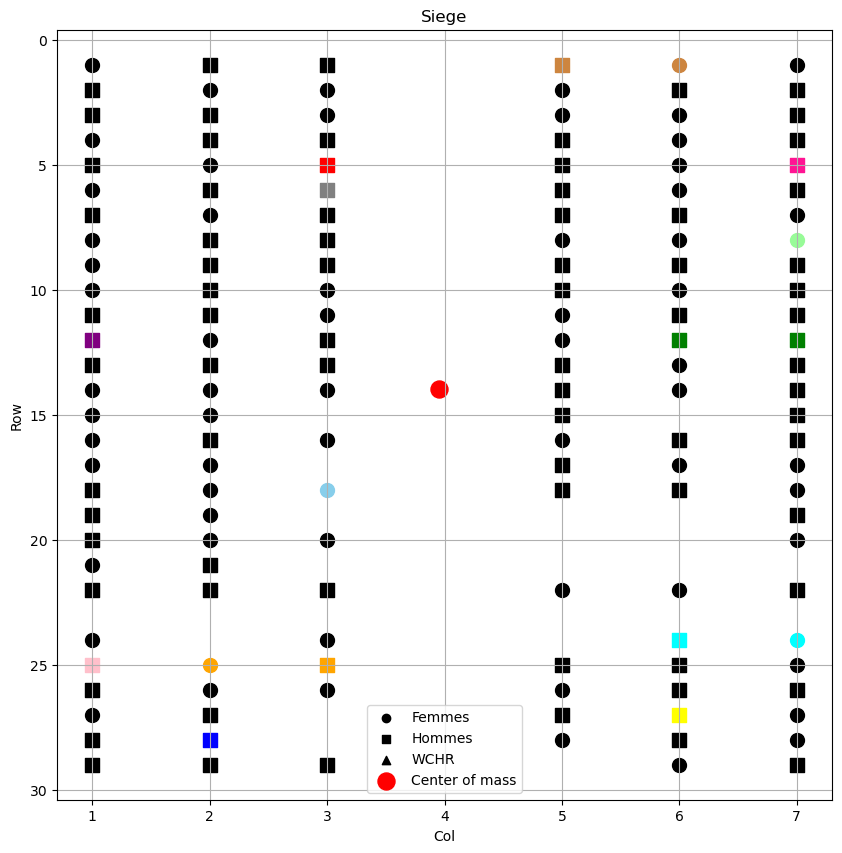

In [14]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)


# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g


x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



# Dictionary to count the frequency of each group
group_counts = defaultdict(int)

# Counting the frequency of each group
for passenger in Passengers.values():
    group_counts[passenger['group']] += 1
# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Femmes': 'o',   # Circule
    'Hommes': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    5: 'green',
    67: 'blue',
    24: 'orange',
    30: 'purple',
    46: 'gray',
    3: 'yellow',
    14: 'cyan',
    23: 'peru',
    76:'palegreen',
    32: 'pink',
    47:'deeppink',
    36:'skyblue'
}

plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape,  s=100)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', s=150, label='Center of mass')  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Siege')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()  # Show legend with gender labels
plt.show()

Evaluation de la satisfaction client

Première métrique qui évalue la satisfaction des passagers pris un par un.
Donc même si le groupe n'est pas bien groupé, si le passager est assis à côté d'au moins un des membres de son groupe, il est satisfait.

In [15]:
#Première métrique de la satisfaction client (chaque passager pris individuellement)
def metrique_groupe_passager():
    sat={}
    s=0
    for i in Passengers:
        sat[i]=0
        for k in Passengers :
            if k !=i and Passengers[i]['group'] == Passengers[k]['group']:
                for j in range (1, ns+1):
                    if S[(i,j)].x:
                        xi, yi = seat_coordinates([j])[0]
                    if S[(k,j)].x:
                        xk, yk = seat_coordinates([j])[0]
                if yi == yk and min([xi, xk]) == max([xi, xk])-1:
                    s = 1
                elif xi == xk and min([yi, yk]) == max([yi, yk])-1:
                    s = 1/2
                elif yi == yk and min([xi, xk]) == 3 and max([xi, xk]) == 5:
                    s = 1/2
            if sat[i] != 1:
                sat[i] = s
    
    return sat

print ( metrique_groupe_passager()) 

def metrique_transit_passager():
    sat= {}

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 0.5
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat
print (metrique_transit_passager()) 

def metrique_globale_passager():

    sat={}
    sat1=metrique_transit_passager()
    sat2=metrique_groupe_passager()
    satisfaction=0
     

    for i in Passengers:
        sat[i]=(sat1[i]+sat2[i])/2
        satisfaction +=sat[i]
    satisfaction = satisfaction/len(Passengers)

    return satisfaction, sat

satisfaction, sat= metrique_globale_passager()

print ("La satisfaction moyenne des clients est de ",satisfaction*100, "%" )

{1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 137: 1, 138: 1, 139

Deuxième métrique : la satisfaction est évaluée à l'échelle du groupe et de manière strice, c'est à dire que certaines configurations sont jugées satisfaisantes, les autres ne l'étant pas.

In [16]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
    return G


In [17]:
#renvoie un dictionnaire dont les groupes sont les clefs et les passagers du groupe les valeurs
def group_dict(Passengers):

    dic={}
    for i in Passengers:
        groupi=groupe(i, Passengers)
        k=Passengers[i]['group']
        if k not in dic:
            dic[k]=groupi
    return dic

group_dico=group_dict(Passengers)
  

In [18]:
def metrique_groupe_stricte(Passengers):
    sat={}
    
    group=group_dict(Passengers)

    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord=seat_coordinates(seats)

        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()

        if len(group[g]) == 1:
            sat[g] = 1

        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:          #X est triée par odre croissant
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0

            else : 
                sat[g] = 0

        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1

                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0

        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):   #Si sur même rangée
                
                if X[len(group[g])-1]-X[0] == len(group[g]): #Si côtes à côtes (l'allée centrale séparera focément le groupe donc prise en compte)
                    sat[g]=1
                else:
                    sat[g]=0
            
            elif Y[1]==Y[0]+1:    #le groupe occupe 2 rangées l'une derrière l'autre
                if all(y <= 3 for y in Y) or all(y >= 5 for y in Y):   #Si les sièges sont du même côté de l'avion
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
                
        else:
            l=len(group[g])
            n_r = (l//7) + 1
            n_p = (l%7) + 1

            if Y[len[Y]-1]-Y[0]+1 == n_r :
                sat[g]=1

            #elif 
            
            else :
                sat[g]=0

    return sat        
            

In [19]:
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(Passengers):

    sat= {}
    

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat



In [20]:
def metrique_globale_stricte(Passengers):
    
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (Passengers)
    
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]

    sat2=metrique_transit_stricte(Passengers)

    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
        

    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)

    #print (list(sat.values()))
    #m=min(list(sat.values()))
    #M=max(list(sat.values()))

    return moyenne, sat_transit, sat_groupe

    
    

In [21]:
moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers)

# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)



La satisfaction moyenne des passagers est de  73.50993377483444 %
La satisfaction moyenne des passagers en transit est de  0.9735099337748344
La satisfaction moyenne des groupes est de  0.3153153153153153


Troisième métrique : "bounding box" for the boxplot visualization

In [22]:
def ponderation(x, y):
    beta = 0.95
    den = (1 - beta) * x + beta * y + 1
    res = 1 / den
    return res

In [23]:
def group_statistics_retan(passengers, seat_coords):
    """
    Calculate group statistics based on the bounding box.

    Args:
        passengers (dict): Dictionary of passengers.
        seat_coords (list): List of seat coordinates.

    Returns:
        dict: A dictionary containing group statistics.
        
    """
    group_dico = group_dict(passengers)  # Get the dictionary of groups
    result = {}  # Dictionary to store the results

    for group, passengers_in_group in group_dico.items():
        group_scores = {}  # Resetting group_scores for each group
        group_coords = [seat_coords[idx - 1] for idx in passengers_in_group]

        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)

        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)

        y_distance = max_y - min_y
        x_distance = max_x - min_x

        # Check if passengers are seated next to each other horizontally
        if x_distance == len(passengers_in_group) and y_distance == 0:
            satisfaction_scores = 1  # All passengers are seated next to each other horizontally

        elif 4 <= len(passengers_in_group) <= 6:
            if x_distance == len(passengers_in_group) + 1:
                satisfaction_scores = 1
            else:
                satisfaction_scores = ponderation(x_distance, y_distance)
                
        else:
            satisfaction_scores = ponderation(x_distance, y_distance)

        for passenger in passengers_in_group:
            group_scores[passenger] = satisfaction_scores

        # Add group information to the result dictionary
        result[group] = {
            "Quantity": len(passengers_in_group),
            "Satisfaction Score": satisfaction_scores
        }

    return result

# Example usage:
group_stats_retan = group_statistics_retan(Passengers, seat_coords)

# Print the results for debugging
"""
for group, stats in group_stats_retan.items():
    print(f"Group {group}:")
    for key, value in stats.items():
        print(f"{key}: {value}")
    print()  # Add a blank line between groups
"""


'\nfor group, stats in group_stats_retan.items():\n    print(f"Group {group}:")\n    for key, value in stats.items():\n        print(f"{key}: {value}")\n    print()  # Add a blank line between groups\n'

In [24]:
def analyze_group_statistics(group_data):

    """Analyzes group statistics based on the provided data."""
    
    quantity_count = {}  # Dictionary to count the number of groups with each quantity
    satisfaction_sum = {}  # Dictionary to sum the satisfaction scores for each quantity
    satisfaction_count = {}  # Dictionary to count the number of groups for each quantity
    max_satisfaction = {}  # Dictionary to store the maximum satisfaction score for each quantity
    min_satisfaction = {}  # Dictionary to store the minimum satisfaction score for each quantity

    for group, stats in group_data.items():
        quantity = stats['Quantity']
        satisfaction_score = stats['Satisfaction Score']

        # Update quantity count
        if quantity in quantity_count:
            quantity_count[quantity] += 1
        else:
            quantity_count[quantity] = 1

        # Update satisfaction sum and count
        if quantity in satisfaction_sum:
            satisfaction_sum[quantity] += satisfaction_score
            satisfaction_count[quantity] += 1
        else:
            satisfaction_sum[quantity] = satisfaction_score
            satisfaction_count[quantity] = 1

        # Update max and min satisfaction scores
        if quantity in max_satisfaction:
            max_satisfaction[quantity] = max(max_satisfaction[quantity], satisfaction_score)
            min_satisfaction[quantity] = min(min_satisfaction[quantity], satisfaction_score)
        else:
            max_satisfaction[quantity] = satisfaction_score
            min_satisfaction[quantity] = satisfaction_score

    # Calculate average satisfaction for each quantity
    average_satisfaction = {quantity: satisfaction_sum[quantity] / satisfaction_count[quantity] for quantity in satisfaction_sum}

    return quantity_count, average_satisfaction, max_satisfaction, min_satisfaction

In [25]:
# Example usage:
group_data_retan = group_stats_retan


quantity_count_r, average_satisfaction_r, max_satisfaction_r, min_satisfaction_r = analyze_group_statistics(group_data_retan)

"""
# Print the results ret
print("Quantity count:", quantity_count_r)
print("Average satisfaction:", average_satisfaction_r)
print("Max satisfaction:", max_satisfaction_r)
print("Min satisfaction:", min_satisfaction_r)
print("\n")
"""


'\n# Print the results ret\nprint("Quantity count:", quantity_count_r)\nprint("Average satisfaction:", average_satisfaction_r)\nprint("Max satisfaction:", max_satisfaction_r)\nprint("Min satisfaction:", min_satisfaction_r)\nprint("\n")\n'

In [26]:
def calculate_group_data(average_satisfaction, max_satisfaction, min_satisfaction):
    group_data = {}

    for quantity in set(average_satisfaction.keys()).union(max_satisfaction.keys(), min_satisfaction.keys()):
        group_data[quantity] = [
            average_satisfaction.get(quantity, 0),
            max_satisfaction.get(quantity, 0),
            min_satisfaction.get(quantity, 0)
        ]

    return group_data

group_data_retan = calculate_group_data(average_satisfaction_r, max_satisfaction_r, min_satisfaction_r)


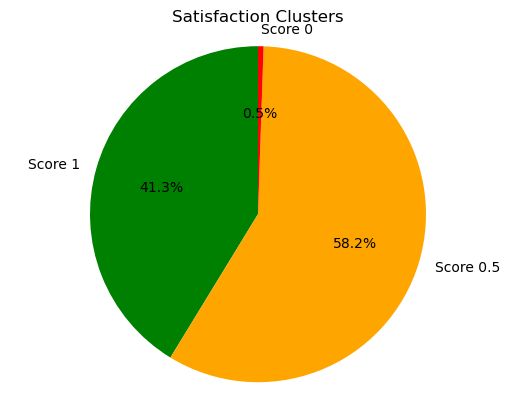

In [27]:
def satisfaction_clusters(group_data):
    """
    Divide the satisfaction scores into clusters based on quartiles.

    Args:
        group_data (dict): Dictionary containing the satisfaction data for each group.

    Returns:
        tuple: A tuple containing three values corresponding to the satisfaction clusters.
    """
    # Extract satisfaction scores
    scores = [entry['Satisfaction Score'] for entry in group_data.values()]

    # Calculate quartiles
    q1, q2, q3 = np.percentile(scores, [25, 50, 75])

    # Divide the data into clusters based on quartiles
    cluster_1 = [score for score in scores if score >= q3]
    cluster_2 = [score for score in scores if q1 <= score <= q3]
    cluster_3 = [score for score in scores if score < q1]

    return len(cluster_1), len(cluster_2), len(cluster_3)

def plot_satisfaction_clusters(group_data):
    """
    Plot a pie chart with satisfaction clusters.

    Args:
        group_data (dict): Dictionary containing the satisfaction data for each group.
    """
    # Calculate satisfaction clusters
    cluster_1, cluster_2, cluster_3 = satisfaction_clusters(group_data)

    # Labels and data for the pie chart
    labels = ['Score 1', 'Score 0.5', 'Score 0']
    sizes = [cluster_1, cluster_2, cluster_3]
    colors = ['green', 'orange', 'red']

    # Create the pie chart
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Ensure the pie chart is circular
    plt.title('Satisfaction Clusters')
    plt.show()


plot_satisfaction_clusters(group_stats_retan)


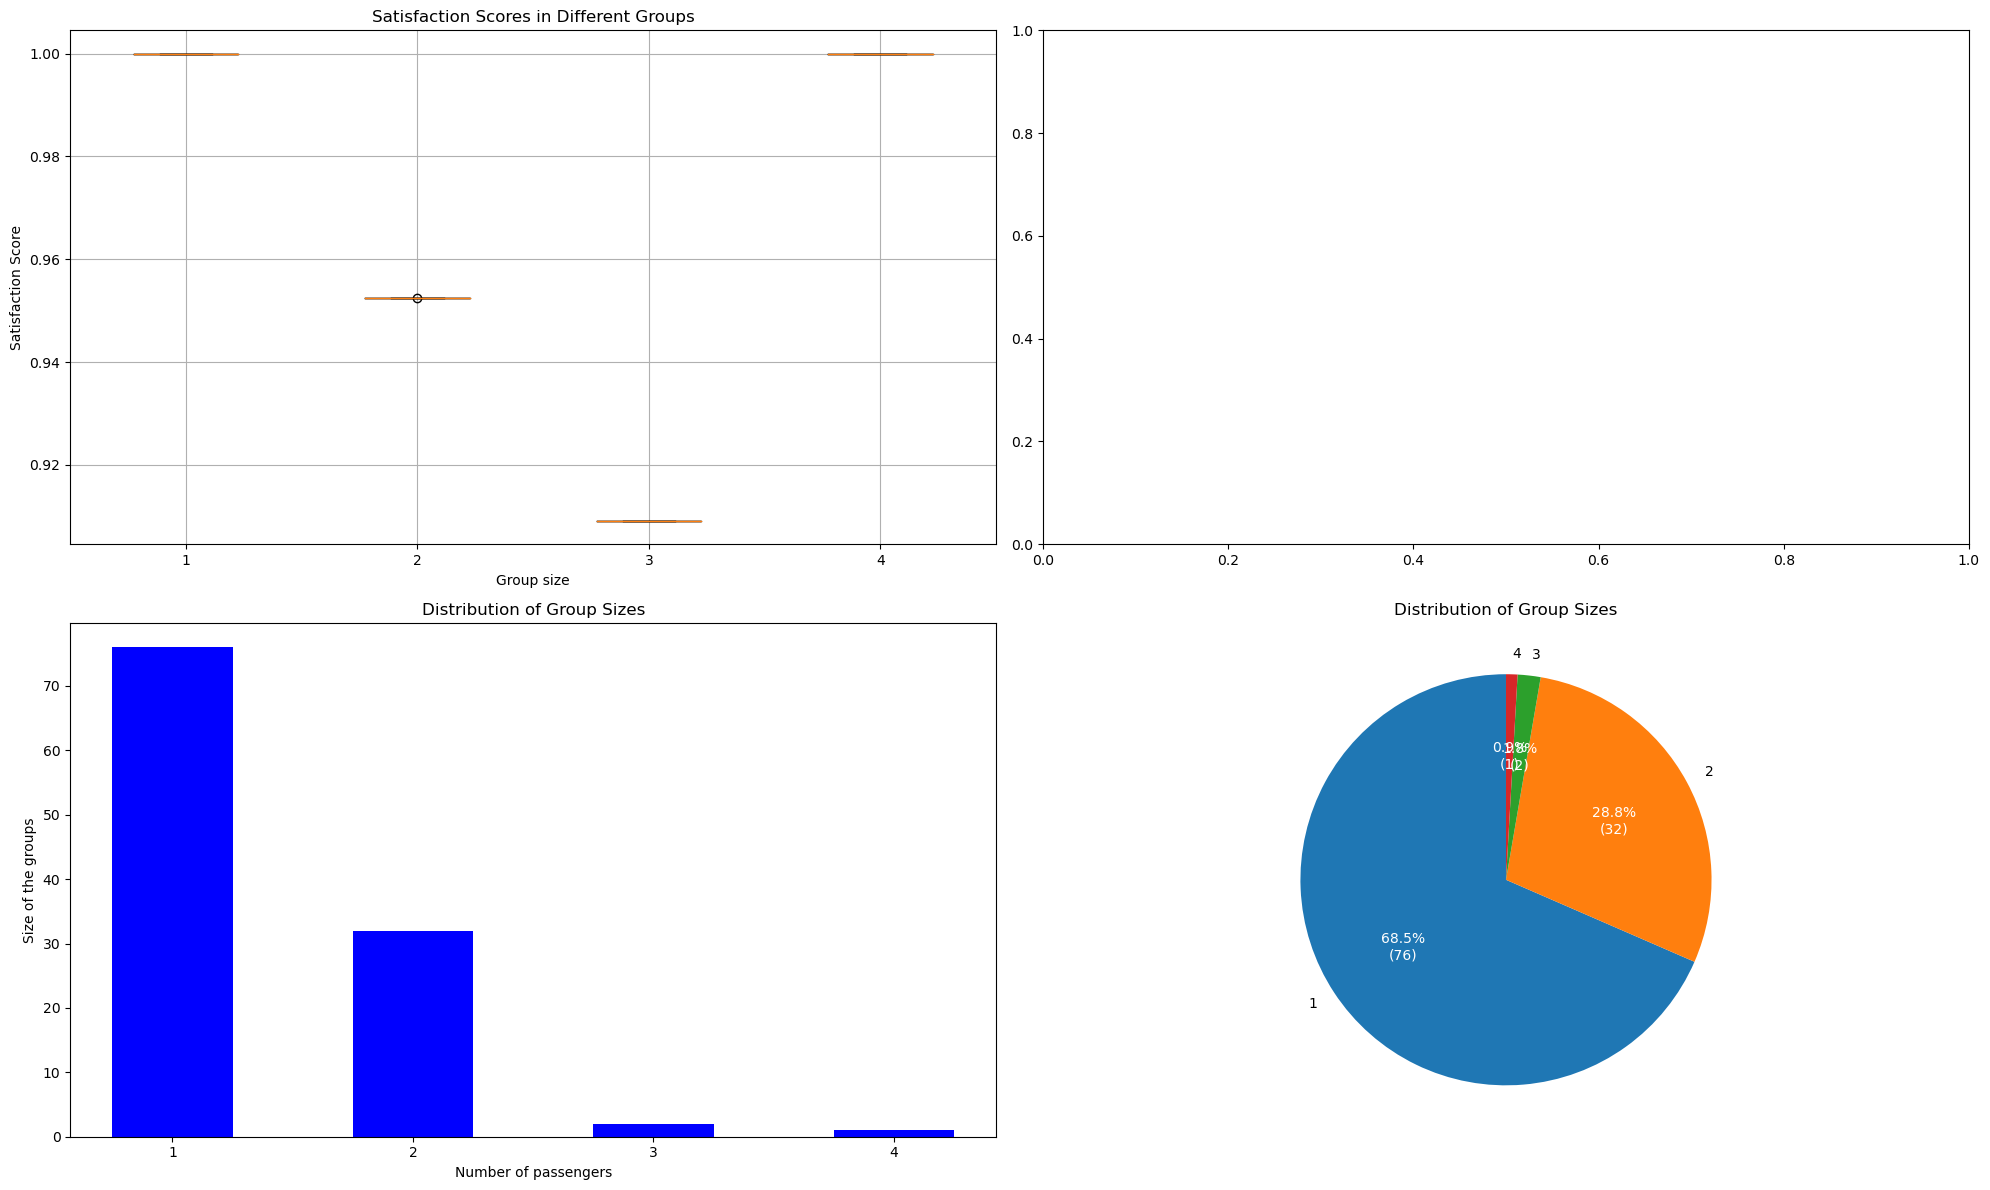

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def update_visualizations(quantity_count, group_data):
    """
    Update boxplot, bar chart, and pie chart visualizations based on group statistics.

    Args:
        quantity_count (dict): Dictionary containing the count of groups with each quantity.
        group_data (dict): Dictionary containing the satisfaction data for each group.
    """
    # Sorting the quantity_count dictionary by keys
    sorted_quantity_count = sorted(quantity_count.items())

    # Extracting data from dictionaries
    group_labels = [quantity for quantity, _ in sorted_quantity_count]  # Extracting only the first value
    sorted_group_data = {quantity: group_data[quantity] for quantity, _ in sorted_quantity_count}

    boxplot_data = [sorted_group_data[quantity] for quantity in group_labels]

    group_sizes = list(quantity_count.values())

    # Creating a figure and axes for the boxplot, bar chart, and pie chart
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Creating the boxplot
    boxplot = ax1.boxplot(boxplot_data, labels=group_labels)

    # Adding labels to the axes
    ax1.set_ylabel('Satisfaction Score')
    ax1.set_xlabel('Group size')
    ax1.set_title('Satisfaction Scores in Different Groups')
    ax1.grid(True)

    #Pie chart
    #plot_satisfaction_clusters(group_stats_retan)

    # Bar chart for group sizes
    x = np.arange(len(group_labels))  # the label locations
    width = 0.5  # the width of the bars
    rects1 = ax3.bar(x, group_sizes, width, label='Group Sizes', align='center', color='blue')
    ax3.set_xticks(x)
    ax3.set_xticklabels(group_labels)  # Update to use group quantities directly
    ax3.set_ylabel('Size of the groups')
    ax3.set_title('Distribution of Group Sizes')
    ax3.set_xlabel('Number of passengers')  # Update x-axis label

    # Creating the pie chart
    def my_autopct(pct):
        absolute = int(np.round(pct / 100.0 * np.sum(group_sizes)))
        return f"{pct:.1f}%\n({absolute:d})"

    pie_wedges, _, autotexts = ax4.pie(group_sizes, labels=group_labels, autopct=my_autopct, startangle=90)
    ax4.set_title('Distribution of Group Sizes')

    
    for autotext in autotexts:
        autotext.set_color('white')  
        autotext.set_fontsize(10)  


    # Displaying the plots
    plt.tight_layout()
    plt.show()

# Example retan:
update_visualizations(quantity_count_r, group_data_retan)


Groupe stricte for waterfall visualization

In [29]:
def metrique_groupe_stricte_new(Passengers):
    sat = {}
    group = group_dict(Passengers)

    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord = seat_coordinates(seats)

        X = [coord[0] for coord in group_coord]
        Y = [coord[1] for coord in group_coord]

        X.sort()
        Y.sort()

        if len(group[g]) == 1:
            sat[g] = {"Quantity": 1, "Satisfaction Score": 1}

        elif len(group[g]) == 2:
            if Y[0] == Y[1] and X[1] == X[0] + 1:
                sat[g] = {"Quantity": 2, "Satisfaction Score": 1}
            elif 3 in X and 5 in X:
                sat[g] = {"Quantity": 2, "Satisfaction Score": 0.5}
            else:
                sat[g] = {"Quantity": 2, "Satisfaction Score": 0}

        elif len(group[g]) == 3:
            if Y[0] == Y[1] == Y[2] and X[1] == X[0] + 1 and X[2] == X[1] + 1:
                sat[g] = {"Quantity": 3, "Satisfaction Score": 1}
            elif (Y[0] == Y[1] == Y[2]) and ((X[1] == X[0] + 1) or (X[2] == X[1] + 1)) and (3 in X and 5 in X):
                sat[g] = {"Quantity": 3, "Satisfaction Score": 0.5}
            else:
                sat[g] = {"Quantity": 3, "Satisfaction Score": 0}

        elif 4 <= len(group[g]) <= 6:
            if all(y == Y[0] for y in Y) and (X[len(group[g]) - 1] - X[0] == len(group[g])):
                sat[g] = {"Quantity": len(group[g]), "Satisfaction Score": 1}
            elif (Y[1] == Y[0] + 1) and (all(y <= 3 for y in Y) or all(y >= 5 for y in Y)):
                sat[g] = {"Quantity": len(group[g]), "Satisfaction Score": 0.5}
            else:
                sat[g] = {"Quantity": len(group[g]), "Satisfaction Score": 0}

        else:
            l = len(group[g])
            n_r = (l // 7) + 1
            n_p = (l % 7) + 1

            if (Y[len(Y) - 1] - Y[0] + 1) == n_r:
                sat[g] = {"Quantity": l, "Satisfaction Score": 1}
            else:
                sat[g] = {"Quantity": l, "Satisfaction Score": 0}

    return sat


group_stats_strict = metrique_groupe_stricte_new(Passengers)

""""
for group, stats in group_stats_strict.items():
    print(f"Group {group}:")
    for key, value in stats.items():
        print(f"{key}: {value}")
    print()  
#"""

'"\nfor group, stats in group_stats_strict.items():\n    print(f"Group {group}:")\n    for key, value in stats.items():\n        print(f"{key}: {value}")\n    print()  \n#'

In [30]:
def count_group_scores_by_quantity(group_stats):
    scores_by_quantity = {}

    for group_data in group_stats.values():
        quantity = group_data["Quantity"]
        satisfaction_score = group_data["Satisfaction Score"]

        if quantity not in scores_by_quantity:
            scores_by_quantity[quantity] = {"0": 0, "0.5": 0, "1": 0}

        if satisfaction_score == 0:
            scores_by_quantity[quantity]["0"] += 1
        elif satisfaction_score == 0.5:
            scores_by_quantity[quantity]["0.5"] += 1
        elif satisfaction_score == 1:
            scores_by_quantity[quantity]["1"] += 1

    # Sort the dictionary by quantity of passengers in ascending order
    scores_by_quantity = dict(sorted(scores_by_quantity.items()))

    return scores_by_quantity

scores_by_quantity = count_group_scores_by_quantity(group_stats_strict)
# Example usage:
"""
scores_by_quantity = count_group_scores_by_quantity(group_stats_strict)
for quantity, scores in scores_by_quantity.items():
    print(f"Group with {quantity} passengers:")
    print("Score 0:", scores["0"])
    print("Score 0.5:", scores["0.5"])
    print("Score 1:", scores["1"])
    print()
"""


'\nscores_by_quantity = count_group_scores_by_quantity(group_stats_strict)\nfor quantity, scores in scores_by_quantity.items():\n    print(f"Group with {quantity} passengers:")\n    print("Score 0:", scores["0"])\n    print("Score 0.5:", scores["0.5"])\n    print("Score 1:", scores["1"])\n    print()\n'

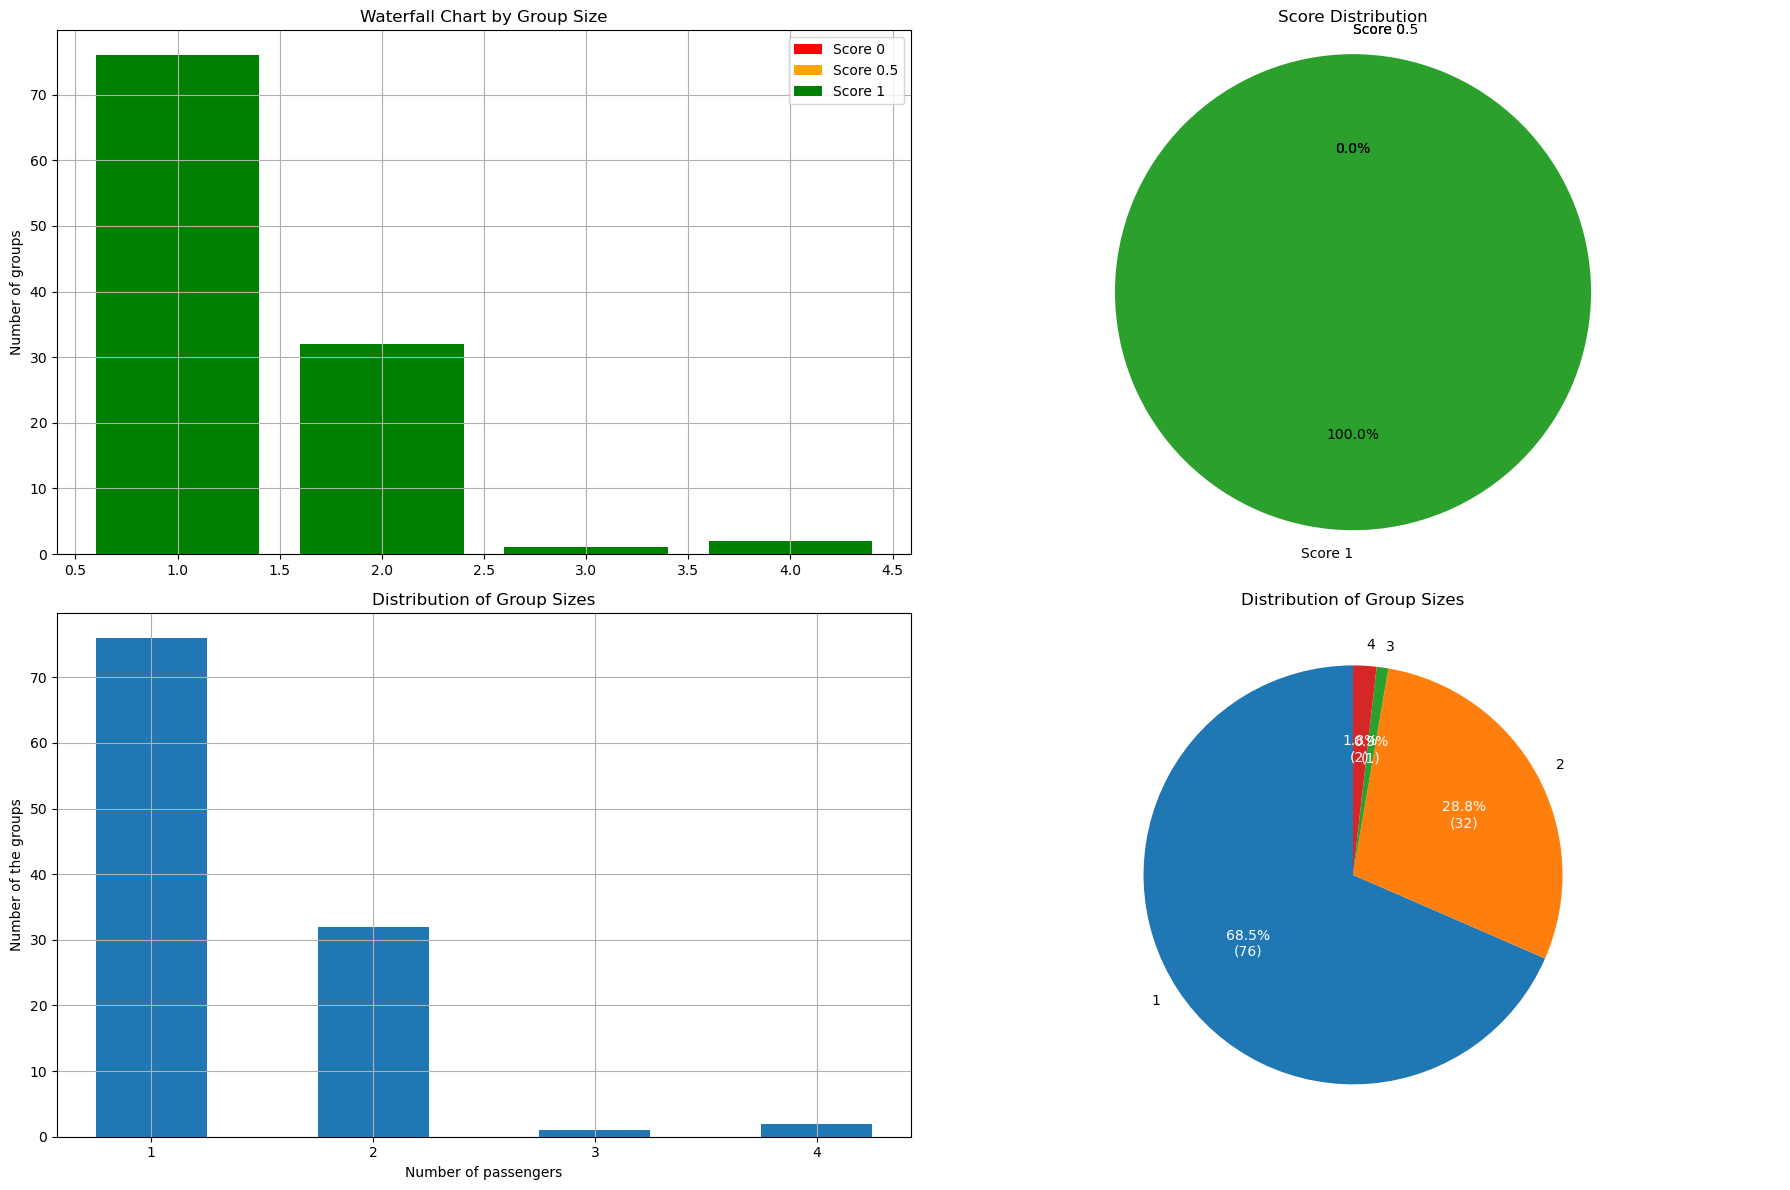

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_waterfall_with_side_charts(scores_by_quantity):
    # Extracting data for the waterfall chart
    group_sizes = [sum(score.values()) for score in scores_by_quantity.values()]
    group_labels = list(scores_by_quantity.keys())  # Update to use group quantities directly
    zero_scores = [score["0"] for score in scores_by_quantity.values()]
    half_scores = [score["0.5"] for score in scores_by_quantity.values()]
    one_scores = [score["1"] for score in scores_by_quantity.values()]

    # Plotting the waterfall chart
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Waterfall chart
    ax1.bar(group_labels, zero_scores, label='Score 0', color='red')
    ax1.bar(group_labels, half_scores, bottom=zero_scores, label='Score 0.5', color='orange')
    ax1.bar(group_labels, one_scores, bottom=np.array(zero_scores) + np.array(half_scores), label='Score 1', color='green')
    ax1.set_ylabel('Number of groups')
    ax1.set_title('Waterfall Chart by Group Size')
    ax1.legend()
    ax1.grid(True)


    # Pie chart for score distribution
    labels = ['Score 0', 'Score 0.5', 'Score 1']
    scores_sum = np.array(zero_scores) + np.array(half_scores) + np.array(one_scores)


    ax2.pie([sum(zero_scores), sum(half_scores), sum(one_scores)], labels=labels, autopct='%1.1f%%', startangle=90)
    ax2.axis('equal')
    ax2.set_title('Score Distribution')

    # Bar chart for group sizes
    x = np.arange(len(group_labels))  # the label locations
    width = 0.5  # the width of the bars
    rects1 = ax3.bar(x, group_sizes, width, label='Group Sizes', align='center')
    ax3.grid(True)
    ax3.set_xticks(x)
    ax3.set_xticklabels(group_labels)  # Update to use group quantities directly
    ax3.set_ylabel('Number of the groups')
    ax3.set_title('Distribution of Group Sizes')
    ax3.set_xlabel('Number of passengers')  # Update x-axis label

    # Creating the pie chart
    def my_autopct(pct):
        absolute = int(np.round(pct / 100.0 * np.sum(group_sizes)))
        return f"{pct:.1f}%\n({absolute:d})"

    pie_wedges, _, autotexts = ax4.pie(group_sizes, labels=group_labels, autopct=my_autopct, startangle=90)
    ax4.set_title('Distribution of Group Sizes')

    # Formatting text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)

    # Displaying the plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_waterfall_with_side_charts(scores_by_quantity)


# Dynamic model

Generation of a random order of registration

In [32]:
def Random_order():

    Clefs = list(group_dico.keys())
    Order = random.sample(Clefs, k=len(Clefs))

    return Order

print(Random_order())

[22, 75, 14, 96, 104, 103, 19, 74, 70, 32, 60, 24, 1, 89, 66, 6, 97, 106, 13, 87, 8, 73, 23, 47, 110, 76, 50, 85, 36, 54, 4, 15, 65, 94, 34, 88, 61, 26, 99, 39, 29, 59, 69, 111, 5, 107, 49, 18, 31, 17, 20, 92, 48, 83, 12, 27, 62, 109, 35, 51, 90, 3, 25, 40, 95, 82, 84, 105, 72, 9, 101, 79, 45, 55, 100, 78, 71, 91, 102, 98, 28, 53, 2, 10, 16, 93, 57, 68, 56, 7, 81, 46, 63, 80, 33, 52, 64, 43, 67, 77, 58, 108, 38, 42, 41, 30, 37, 86, 44, 21, 11]


Modeling 1 : Proposition of seats for the group by only considering groups of the same size

In [33]:
def possible_choice (n_group):

    Choices=[]
    groups_dict =group_dict(Passengers)   #on récupère le dictionnaire {group: [passagers]}
    group = groups_dict[n_group]           #liste des passagers du groupe n°n_group

    for g in groups_dict:
        if len(groups_dict[g]) == len(group):   #On récupère la position des sièges pour des groupes de même taille
            C=[]
            for i in groups_dict[g]:
                for j in range (1, ns+1):
                    if temoin_S[(i,j)]:
                        C += [j]
            if C != []:
                Choices+=[C]

    return Choices

Modeling 2 : Proposition of seats for the group by considering all combinations of sizes

First we consider a function that returns the possibilities for a group considering the seats of groups of same size

In [34]:
def possible_choice_same_size (group_size, S_dyn):

    Choices=[]
    for g in group_dico:
        if len(group_dico[g]) == group_size:   #On récupère la position des sièges pour des groupes de même taille
            C=[]
            for i in group_dico[g]:
                for j in range (1, ns+1):
                    if S_dyn[(i,j)]:
                        C += [j]
            if C != []:
                Choices+=[C]

    return Choices

Then we add combinations of seats by concatening the results of the previous function for groups such that the sum of their size is equal to the size of the group we consider. We filter the combinations by allowing only concatenations of seats on the same row.
We obtain a list with all the interesting possibilities.

In [35]:
def possible_choice (size, S_dyn):

    Choices = possible_choice_same_size(size, S_dyn)
    for k in range (1, size//2 +1):
        
        choices1 = possible_choice_same_size(size-k, S_dyn)
        choices2 = possible_choice_same_size(k, S_dyn)
        choices1.sort()
        choices2.sort()
        
        for choice in choices1:
            
            coord=seat_coordinates(choice)
            X1=[]
            Y1=[]
            for i in range (len(coord)):
                X1 += [coord [i][0]]
                Y1 += [coord [i][1]]
            X1.sort()
            Y1.sort()
            for places in choices2:
                coord2=seat_coordinates(places)
                X2=[]
                Y2=[]
                for i in range (len(coord2)):
                    X2 += [coord2 [i][0]]
                    Y2 += [coord2 [i][1]]
                X2.sort()
                Y2.sort()

                if all(y1==Y1[0] for y1 in Y1) and all(y2 == Y2[0] for y2 in Y2) and Y1[0] == Y2[0]:
                    if all(place not in choice for place in places):
                        C = choice + places
                        Choices += [C]

    return Choices
            
#possible_choice(3, temoin_S)

We supress from the propositions the seats already chosen by previous groups

In [36]:
def group_choices_available(choices, Choice_dict):
    choices_copy=choices.copy()
    for choice in choices:
        for taken in Choice_dict.values():
            for place in choice :
                if place in taken and choice in choices_copy:
                    choices_copy.remove(choice)
            
    return choices_copy

We supress from the propositions the seats in the front rows if the group is not in transit

In [42]:
def transit_filter (n_group, Choices):
    
    Choices_copy=Choices.copy()
    group = group_dico[n_group]           #liste des passagers du groupe n°n_group
    group_time=Passengers[group[0]]['connection_time']   #temps de transit du group n_group

    #Si groupe en transit, on lui propose toutes les places
    if group_time > 0 and group_time <= 120 :
        return Choices
    
    #Sinon, on supprime des propositions les places situées dans les 7 premiers rangs
    else : 
        for choice in Choices:
            coord=seat_coordinates(choice)
            X=[]
            Y=[]
            for i in range (len(coord)):
                X += [coord [i][0]]
                Y += [coord [i][1]]
            if all(y<=7 for y in Y) and len(Choices_copy) > 1:
                Choices_copy.remove(choice)

    return Choices_copy


We supress from the propositions the seats which don't respect the barycenter constraint

In [43]:

def barycenter_filter(group, choices, S_dyn):   #group est le numéro du groupe, choice est une liste de listes de sièges

    group_passengers = group_dico[group]   #liste des passagers du groupe
    for choice in choices :
        S_bar = S_dyn.copy()              #On initialise le dictionaire des attributions avec les attributions courantes

        #Random attribution of the seats to the passengers
        random_attribution = [i for i in range(len(group_passengers))]
        random_attribution = random.sample(random_attribution, k=len(random_attribution))   #Liste mélangée des indices des passagers
        for k in random_attribution :
            i = group_passengers[random_attribution[k]]
            j = choice[k]

           
            for p in Passengers :
                if S_bar[(p,j)] == 1 :
                    exchanged_passenger = p              #On trouve le passager avec lequel on a échangé les places
                    for s in range (1, ns+1):
                        if S_bar[(i,s)] == 1:             #On trouve l'ancien siège occupé par i
                            old_seat = s
            
            #On intervertit les passagers
            S_bar[(i,j)] = 1
            S_bar[(i,old_seat)] = 0
            S_bar[(exchanged_passenger,j)] = 0
            S_bar[(exchanged_passenger,old_seat)] = 1   #important de terminer par une attribution égale à 1 dans le cas où i=p et j=s

        if len(group_passengers) != 1 or Passengers[group_passengers[0]]['gender'] != Passengers[exchanged_passenger]['gender']:
            #On calcule le centre de masse correspondant à ce choix
            x_g = 0
            y_g = 0
            total_weight = sum(Passengers[i]['weight'] for i in range(1, n + 1))
            for i in range(1, n + 1):
                j_k = 1
                weight_ij = Passengers[i]['weight'] / total_weight

                for j in range(1, ns + 1):
                    if (j % 7 == 0):
                        x_g += (7 * S_bar[i, j] * weight_ij)
                        y_g += (j_k * S_bar[i, j] * weight_ij)
                        j_k += 1
                    else:
                        x_g += ((j % 7) * S_bar[i, j] * weight_ij)
                        y_g += (((j // 7) + 1) * S_bar[i, j] * weight_ij)

            if x_g < 3 or x_g > 5 or y_g < 13 or y_g > 17 :   #Si contrainte de barycentre non respectée, on supprime la possibilité de la liste des choix
                if len(choices) !=1:
                    choices.remove(choice)

    return choices


We give each proposition a score based on the satisfaction criteria used in the static model

In [44]:
def assign_values(group, choices):
    choices_with_values = []
    for choice in choices:
        score =0 

        #Coordonnées des sièges
        coord = seat_coordinates(choice)
        X=[]
        Y=[]
        for i in range (len(coord)):
            X += [coord [i][0]]
            Y += [coord [i][1]]
            X.sort()
            Y.sort()

        #Group in transit
        if date[group][3] > 0 and date[group][3] <= 120 : 
            if all(y <=6 for y in Y):
                score +=0.7
            else :
                score += 0
        else :
            score += 0.7
        
        #Groups together

        #Group of 1, the satisfaction is higher when next to the window or the central aisle
        if len(choice) == 1:
            if X[0] != 2 or X[0] != 6:
                score = random.random()/2
            else :
                score +=0

        
        #Group of 2 or 3
        elif  len(choice) == 2 or len(choice) == 3:
            if all(y == Y[0] for y in Y):   #Sur la même rangée
                if X[len(X)-1]-X[0] + 1 == len(choice): #Si côtes à côtes (non sépérés par l'allée centrale)         #X est triée par odre croissant
                    score += 1/2
                elif (3 in X and 5 in X):
                    score += 1/4
                else : 
                    score += 0

            else : 
                score += 0

        #Groups of 4 to 6 passengers
        elif  len(choice) > 3 and len(choice) <= 6:
            if all(y == Y[0] for y in Y):   #Si sur même rangée
                
                if X[len(X)-1]-X[0] == len(X): #Si côtes à côtes (l'allée centrale séparera focément le groupe donc prise en compte)
                    score +=1
                else:
                    score +=0
            
            elif Y[len(Y)-1]==Y[0]+1:    #le groupe occupe 2 rangées l'une derrière l'autre
                if all(y <= 3 for y in Y) or all(y >= 5 for y in Y):   #Si les sièges sont du même côté de l'avion
                    score +=1/2
                else:
                    score +=0
            else :
                score+=0   
                
        else :
            l=len(choice)
            n_r = (l//7) + 1
            n_p = (l%7) + 1

            if Y[len[Y]-1]-Y[0]+1 == n_r :
                score += 0.5
            else :
                score +=0

        choices_with_values.append((choice, score)) 
    return choices_with_values

The group will choose the proposition with the highest score

In [45]:
def group_choice(choices_with_values):

    sorted_choices = sorted(choices_with_values, key=lambda x: x[1], reverse=True)
    group_choices = [choice[0] for choice in sorted_choices]
    group_choice = group_choices[0]
    
    return group_choice


# group_choices_sorted = group_choice(choices_with_values)
# print(group_choices_sorted)


We run the dynamic model for every group

In [46]:

def dynamic_model():

    S_dyn=temoin_S.copy()    #On initialise le dictionnaire des attributions du modèle dynamique avec celui du modèle statique.
    Choices_dict ={}
    satis_choice_dict = {}

    order = Random_order()
    
    for group in order:
        
        size=len(group_dico[group])
        choices = possible_choice (size, S_dyn)
        choix_moins=group_choices_available(choices, Choices_dict)
        choix_transit = transit_filter(group, choix_moins)
        choix_bar=barycenter_filter(group, choix_transit, S_dyn)
        
        
        choix_tries=assign_values(group, choix_bar)
        choice = group_choice(choix_tries)

        Choices_dict[group]=choice    #On ajoute le choix du groupe au dict des choix

        group_passengers = group_dico[group]    #Liste des passagers du groupe group

        #on relève le nombre de choix possibles pour le groupe, sa taille et son ordre de passage
        satis_choice_dict[order.index(group)]= {'group_len':len(group_passengers),'number_choices':len(choix_bar)}    

        #We get the ancient seats of the group, ordered 
        Ancient_seats =[]
        for passenger in group_passengers:
            for s in range (1, ns+1):
                if S_dyn[(passenger, s)] == 1:
                    Ancient_seats += [s]
        Ancient_seats.sort()                      #Trier cette liste revient à attribuer de manière aléatoire les places

        k=0
        for seat in choice:   #Par construction, l'ordre des places dans choice conserve l'ordre des groupes
            s = Ancient_seats[k]       #On récupère les sièges d'Ancient_seats dans l'ordre
            for p in Passengers :
                if S_dyn[(p,seat)] == 1 :
                    exchanged_passenger = p
                    for passenger in group_passengers:
                        if S_dyn[(passenger, s)] == 1:
                            new_passenger = passenger
            S_dyn[(exchanged_passenger, seat)] = 0
            S_dyn[(new_passenger, s)] = 0
            S_dyn[(exchanged_passenger, s)] = 1
            S_dyn[(new_passenger, seat)] = 1   #important de terminer par une attribution égale à 1 dans le cas où new_passenger=exchanged_passenger 

            k+=1
            
    return S_dyn, satis_choice_dict

In [47]:
S_dyn, satis_dict = dynamic_model()

Vizualisation of the dynamic allocation

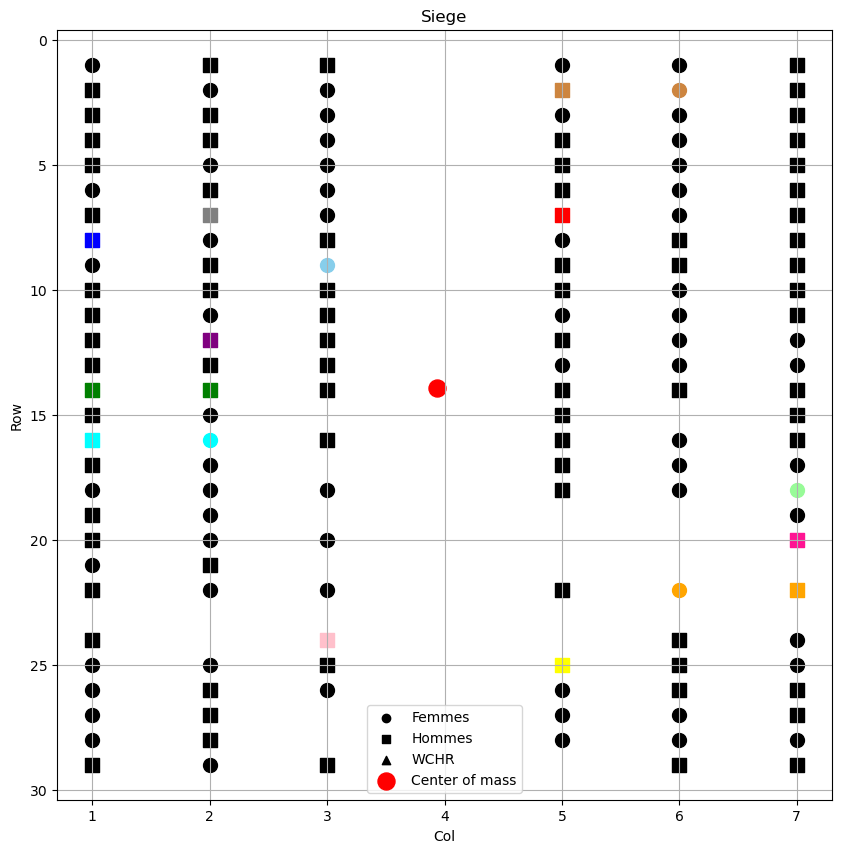

In [48]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S_dyn[(i, j)]]
seat_coords = seat_coordinates(seats)


# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = 0
    y_g = 0
    total_weight = sum(Passengers[i]['weight'] for i in range(1, n + 1))

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S_dyn[i, j] * weight_ij)
                y_g += (j_k * S_dyn[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S_dyn[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S_dyn[i, j] * weight_ij)

    return x_g, y_g


x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



# Dictionary to count the frequency of each group
group_counts = defaultdict(int)

# Counting the frequency of each group
for passenger in Passengers.values():
    group_counts[passenger['group']] += 1
# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Femmes': 'o',   # Circule
    'Hommes': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    5: 'green',
    67: 'blue',
    24: 'orange',
    30: 'purple',
    46: 'gray',
    3: 'yellow',
    14: 'cyan',
    23: 'peru',
    76:'palegreen',
    32: 'pink',
    47:'deeppink',
    36:'skyblue'
}

plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape,  s=100)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g, y_g, color='red', marker='o', s=150, label='Center of mass')  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Siege')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()  # Show legend with gender labels
plt.show()

## Satisfaction evaluation for the dynamic model

In [52]:
print ([[ordre, satis_dict[ordre]['number_choices']] for ordre in satis_dict if satis_dict[ordre]['group_len'] == 3])

[[91, 4]]


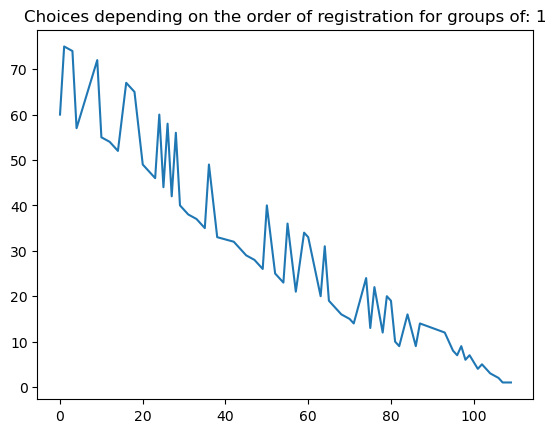

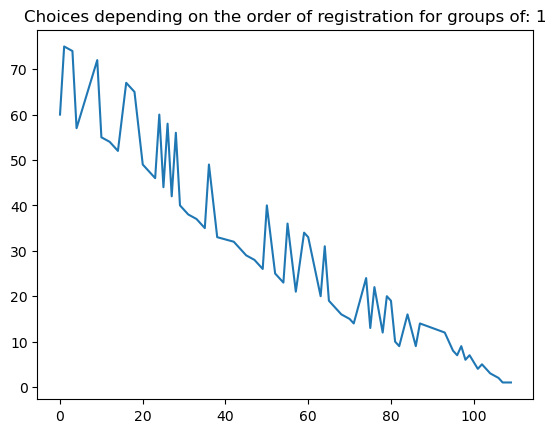

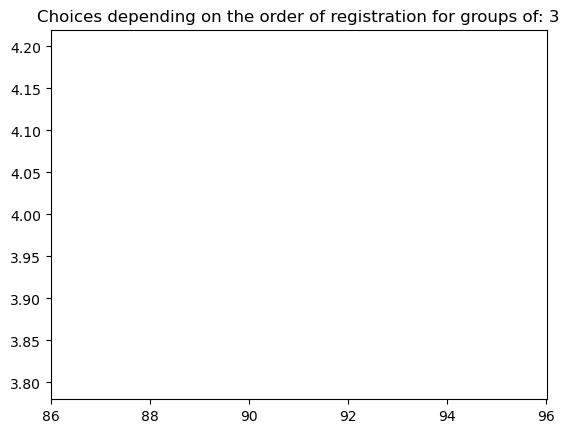

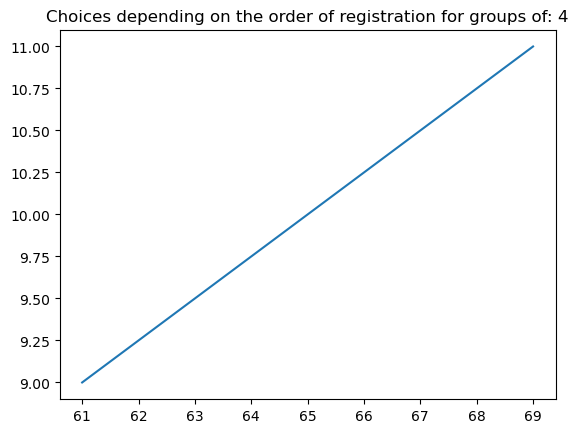

In [53]:
def choices_number (l):

    O =[]
    N=[]
    dynamic_argument = l

    for ordre in satis_dict :
        if satis_dict[ordre]['group_len'] == l:
            O+=[ordre]
            nb_choices = satis_dict[ordre]['number_choices']
            N+=[nb_choices]

    
    plt.plot(O, N)
    plt.title(f'Choices depending on the order of registration for groups of: {dynamic_argument}')
    plt.show()


choices_number(1)
choices_number(1)
choices_number(3)
choices_number(4)

    